# Notebook to classify power plants
Variables include:
- Fuel type
- Historical ramp speeds
- Historical efficiency
- Location?

In [17]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn as sk

### Variable definitions

These variables will be used to cluster the power plants.
- year: year that the data is for
- fuel type: primary fuel type used at the facility (SUB, LIG, NG, etc)
- 1-hr ramp rate: maximum or 95 percentile rate of generation increase over 1 hour
- 3-hr ramp rate: maximum or 95 percentile rate of generation increase over 3 hours
- efficiency: might just change this to heat rate (MMBTU/MWh)
- efficiency std: standard deviation in efficiency based on monthly values for the year
- CF: capacity factor, which is the amount generated in a year divided by the theoretical maximum generation possible $MWh/(Capacity * 8760)$ (or hours per month for monthly values used in calculating the standard deviation)
- CF std: standard deviation of CF based on monthly values for the year

In [2]:
# cols = ['year', 'fuel type', '1-hr ramp rate', '3-hr ramp rate',
#         'efficiency', 'efficiency std', 'CF', 'CF std']

# #Add index of power plant IDs
# df = pd.DataFrame(columns=cols)

In [3]:
filename = 'Cluster_Data.csv'
path = '../Clean Data'
fullpath = os.path.join(path, filename)

cluster_df = pd.read_csv(fullpath)

##### missing '1-hr ramp rate'

In [4]:
cluster_df[cluster_df.plant_id==127]

,year,plant_id,capacity,capacity_factor,efficiency,ramp_rate,fuel_type
0,2007,127,720.0,0.673762,0.322937,448.0,SUB
216,2008,127,720.0,0.663369,0.322089,275.0,SUB
450,2009,127,720.0,0.450726,0.313565,277.0,SUB
695,2010,127,720.0,0.583774,0.323464,302.0,SUB
948,2011,127,720.0,0.543626,0.318966,341.0,SUB
1205,2012,127,720.0,0.499563,0.325519,266.0,SUB
1479,2013,127,720.0,0.635520,0.331127,293.0,SUB
1761,2014,127,720.0,0.515289,0.329987,306.0,SUB
2052,2015,127,720.0,0.333515,0.307468,300.0,SUB


In [5]:
cluster_df[cluster_df.plant_id==3466]

,year,plant_id,capacity,capacity_factor,efficiency,ramp_rate,fuel_type
11,2007,3466,2314.5,-0.000217,-inf,NaN,AB
229,2008,3466,2314.5,-0.000109,-inf,NaN,AB
462,2009,3466,NaN,NaN,-inf,NaN,AB


In [6]:
cluster_df[cluster_df.plant_id==3584]

,year,plant_id,capacity,capacity_factor,efficiency,ramp_rate,fuel_type
35,2007,3584,2.4,0.530517,0.345203,NaN,WAT
251,2008,3584,2.4,0.356546,0.346259,NaN,WAT
484,2009,3584,2.4,0.214814,0.349580,NaN,WAT
728,2010,3584,2.4,0.530065,0.349732,NaN,WAT
978,2011,3584,2.4,0.200446,0.351166,NaN,WAT
1235,2012,3584,2.4,0.000000,NaN,NaN,AB
1509,2013,3584,2.4,0.175221,0.357609,NaN,WAT
1791,2014,3584,2.4,0.110054,0.358795,NaN,WAT
2081,2015,3584,2.4,0.376490,0.366289,NaN,WAT


In [7]:
cluster_df['fuel_type'].unique()

array(['SUB', 'LIG', 'WAT', 'NG', 'AB', 'NUC', 'PC', 'BLQ', 'DFO', 'WH',
       'LFG', 'OTH', 'PUR', 'WND', 'OBL', 'OBG', 'SUN', 'WDS'], dtype=object)

## Filter out non-fossil plants

In [8]:
fossil_codes = ['SUB', 'LIG', 'NG', 'DFO', 'PC']
fossil_df = cluster_df.loc[cluster_df['fuel_type'].isin(fossil_codes)]

In [10]:
fossil_df.describe()

,year,plant_id,capacity,capacity_factor,efficiency,ramp_rate
count,1253.000000,1253.000000,1248.000000,1248.000000,1253.000000,452.000000
mean,2010.994413,31636.021548,578.804808,0.387492,0.344288,354.559735
std,2.592839,24320.115380,572.050665,0.409746,2.017096,252.311950
min,2007.000000,127.000000,1.100000,-0.532227,-70.714475,1.000000
25%,2009.000000,4939.000000,138.000000,0.089781,0.291003,177.750000
50%,2011.000000,50118.000000,497.900000,0.399671,0.357607,305.500000
75%,2013.000000,55137.000000,861.000000,0.598321,0.470370,456.750000
max,2015.000000,59381.000000,4008.400000,10.951877,3.657021,1985.000000


In [12]:
# Unique plants
len(fossil_df.dropna().loc[:,'plant_id'].unique())

58

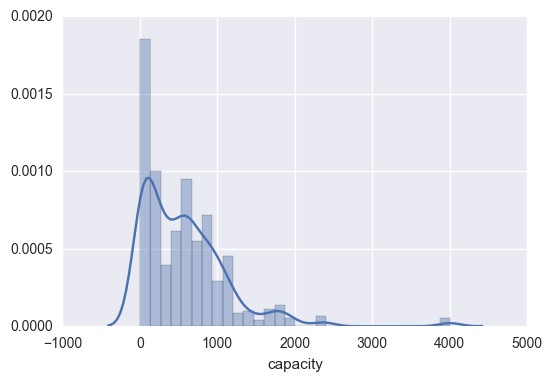

In [14]:
sns.distplot(fossil_df['capacity'].dropna())

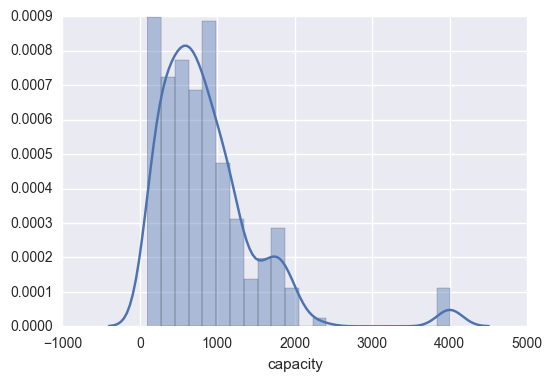

In [16]:
fossil_with_ramp = fossil_df.dropna()
sns.distplot(fossil_with_ramp['capacity'])

## Start classifying only with all nan values dropped

In [65]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabaz_score
from sklearn import preprocessing

In [20]:
fossil_with_ramp.columns

Index([u'year', u'plant_id', u'capacity', u'capacity_factor', u'efficiency',
       u'ramp_rate', u'fuel_type'],
      dtype='object')

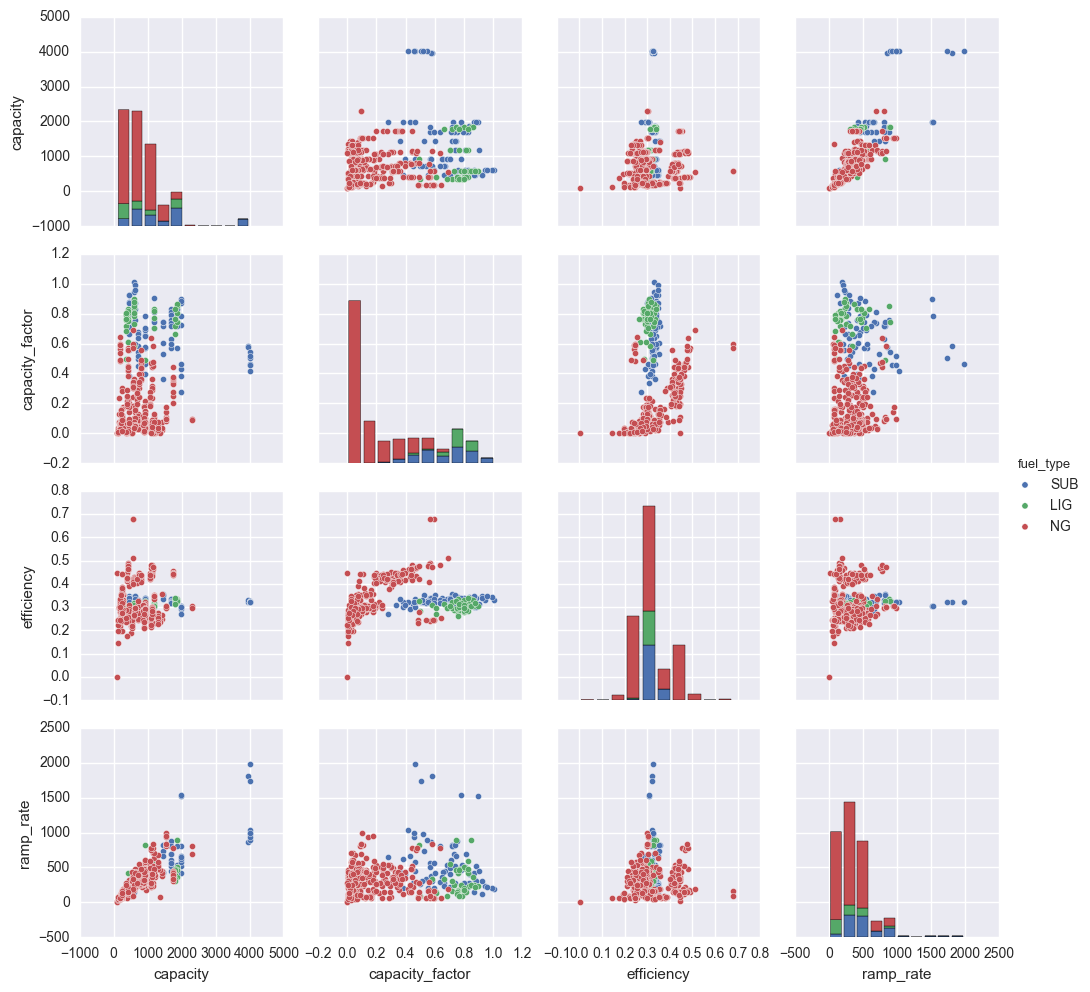

In [23]:
sns.pairplot(fossil_with_ramp, hue='fuel_type', vars=[u'capacity', u'capacity_factor', u'efficiency',
       u'ramp_rate'])

The code below begins by scaling the X-vector data to mean 0 and a standard variance. It then loops through a wide range of k values for the number of clusters (3 to 14), calculating the labels for each plant, the [Calinski Harabaz score](http://scikit-learn.org/stable/modules/clustering.html#calinski-harabaz-index), and the [Silhouette score](http://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient) for each value of k.

In [77]:
cluster_data = pd.DataFrame(index=range(3,15), columns=['n_clusters', 'score', 'silhouette'])
cluster_labels = {}

X = fossil_with_ramp[['capacity', 'capacity_factor', 'efficiency', 'ramp_rate']]
X_scaled = preprocessing.StandardScaler().fit_transform(X)

for idx, n_clusters in enumerate(range(3,15)):
    cluster_data.loc[n_clusters, 'n_clusters'] = n_clusters
    clusterer = KMeans(n_clusters, random_state=42)


    # fit_clusters = clusterer.fit(X)
#     cluster_labels = clusterer.fit_predict(X)
    cluster_labels[n_clusters] = clusterer.fit_predict(X_scaled)
    
    # http://scikit-learn.org/stable/modules/clustering.html#calinski-harabaz-index
    # The score is higher when clusters are dense and well separated
#     score[idx] = metrics.calinski_harabaz_score(X, cluster_labels)
    cluster_data.loc[n_clusters, 'score'] = calinski_harabaz_score(X_scaled, cluster_labels[n_clusters])
     
#     silhouette[idx] = silhouette_score(X, cluster_labels)
    cluster_data.loc[n_clusters, 'silhouette'] = silhouette_score(X_scaled, cluster_labels[n_clusters])
    
#     print 'For ', n_clusters, ' clusters, the average silhouette score is :', silhouette[idx], \
#         ' and the score is :', score[idx]

The two score values are plotted below. They don't agree exactly on the optimal number of centers, but it looks like 6 or 8 is probably best.

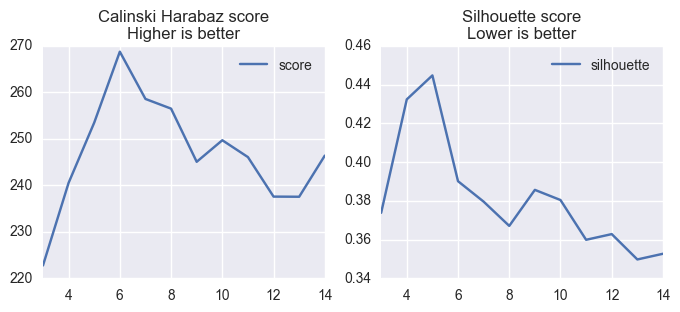

In [78]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
cluster_data.plot(y='score', ax=ax1)
# ax1.plot(range(3,15), cluster_data['score'])
ax1.set_title('Calinski Harabaz score\nHigher is better')
cluster_data.plot(y='silhouette', ax=ax2)
# ax2.plot(range(3,15), silhouette)
ax2.set_title('Silhouette score\nLower is better')

The integer appended to each of the `cluster_id` column labels is equal to the number of clusters.

In [72]:
for n_clusters in cluster_labels.keys():
    fossil_with_ramp.loc[:,'cluster_id_{}'.format(n_clusters)] = cluster_labels[n_clusters]

In [73]:
fossil_with_ramp.head()

,year,plant_id,capacity,capacity_factor,efficiency,ramp_rate,fuel_type,cluster_id_3,cluster_id_4,cluster_id_5,cluster_id_6,cluster_id_7,cluster_id_8,cluster_id_9,cluster_id_10,cluster_id_11,cluster_id_12,cluster_id_13,cluster_id_14
0,2007,127,720.0,0.673762,0.322937,448.0,SUB,0,1,4,1,2,3,7,6,8,5,0,3
1,2007,298,1849.8,0.847509,0.336819,889.0,LIG,1,3,3,5,1,2,3,0,1,3,5,10
5,2007,3439,187.2,0.489432,0.279137,93.0,NG,2,1,4,1,2,3,7,6,5,5,11,8
6,2007,3452,927.5,0.071029,0.276760,467.0,NG,2,0,2,4,3,6,4,7,9,6,1,1
7,2007,3453,958.3,0.045520,0.248375,220.0,NG,2,0,2,4,3,6,4,7,9,11,6,9


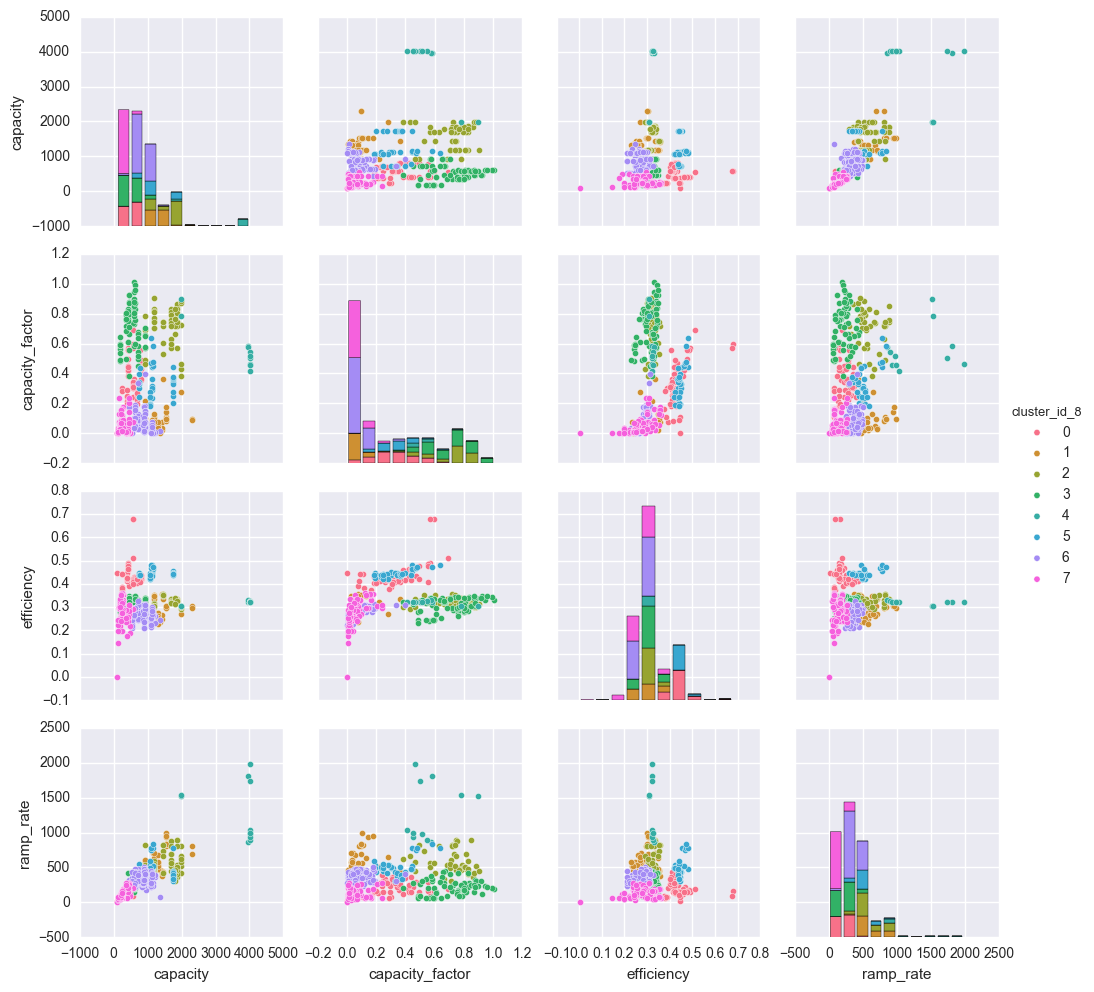

In [74]:
sns.pairplot(fossil_with_ramp, hue='cluster_id_8', vars=[u'capacity', u'capacity_factor', u'efficiency',
       u'ramp_rate'])

### Some basic information about each of the clusters
I've created a bunch of tables and figures to better understand each of the clusters (k=6). The tables show mean, count, and variance. The first figure shows the number of power plants in each group (remember that each power plant is included for every year it operates and data is available). The second looks at the size (capacity). Finally, there is a figure with facets for mean Capacity, Capacity Factor, Efficiency, and Ramp Rate.

In [83]:
drop_columns = ['cluster_id_{}'.format(i) for i in [3,4,5,7,8,9,10,11,12,13,14]]
grouped = fossil_with_ramp.drop(drop_columns, axis=1).groupby(['cluster_id_6', 'fuel_type'])

In [86]:
grouped.mean()

year      plant_id     capacity  \
cluster_id_6 fuel_type                                           
0            SUB        2010.545455   3956.727273  3632.436364   
1            LIG        2011.000000   6620.333333   449.933333   
             NG         2010.600000   6936.400000   177.480000   
             SUB        2010.514286   4863.400000   647.631429   
2            NG         2010.989691   7397.752577   319.493814   
3            NG         2011.567901  36054.098765   794.380247   
4            NG         2010.738806   3732.768657   949.963433   
             SUB        2015.000000   3154.000000   826.000000   
5            LIG        2011.066667   3503.866667  1592.666667   
             NG         2010.333333  12065.166667  1819.000000   
             SUB        2011.666667   5220.030303  1605.030303   

                        capacity_factor  efficiency    ramp_rate  
cluster_id_6 fuel_type                                            
0            SUB               0.562837    0.320940  1297.818182  
1            LIG               0.761921    0.294525   183.629630  
             NG                0.557092    0.247173    70.500000  
             SUB               0.726930    0.333776   283.228571  
2            NG                0.062944    0.280602   148.278351  
3            NG                0.336582    0.442339   333.012346  
4            NG                0.062295    0.275766   411.604478  
             SUB               0.364583    0.309290   356.000000  
5            LIG               0.757606    0.322619   535.400000  
             NG                0.175327    0.327332   861.000000  
             SUB               0.671071    0.322254   597.303030

In [87]:
grouped.count()

year  plant_id  capacity  capacity_factor  efficiency  \
cluster_id_6 fuel_type                                                          
0            SUB          11        11        11               11          11   
1            LIG          27        27        27               27          27   
             NG           10        10        10               10          10   
             SUB          35        35        35               35          35   
2            NG           97        97        97               97          97   
3            NG           81        81        81               81          81   
4            NG          134       134       134              134         134   
             SUB           2         2         2                2           2   
5            LIG          15        15        15               15          15   
             NG            6         6         6                6           6   
             SUB          33        33        33               33          33   

                        ramp_rate  
cluster_id_6 fuel_type             
0            SUB               11  
1            LIG               27  
             NG                10  
             SUB               35  
2            NG                97  
3            NG                81  
4            NG               134  
             SUB                2  
5            LIG               15  
             NG                 6  
             SUB               33

In [88]:
grouped.std()

year      plant_id    capacity  capacity_factor  \
cluster_id_6 fuel_type                                                        
0            SUB        2.733629   1082.899819  817.134177         0.149030   
1            LIG        2.631174    352.936800  104.469517         0.094139   
             NG         2.875181   1228.861099    3.415260         0.054388   
             SUB        2.582423   2628.913667  162.406257         0.165057   
2            NG         2.612051  12764.517451  159.050498         0.058747   
3            NG         2.592963  24573.272814  412.234976         0.136216   
4            NG         2.530800    958.560574  242.871163         0.049207   
             SUB        0.000000   4280.824453  149.906638         0.043937   
5            LIG        2.763710   2596.126672  343.490334         0.092459   
             NG         3.559026  21078.267485  377.078241         0.136531   
             SUB        2.273030   2158.024480  318.325302         0.161161   

                        efficiency   ramp_rate  
cluster_id_6 fuel_type                          
0            SUB          0.007471  423.626916  
1            LIG          0.013392   77.299691  
             NG           0.012571    9.046178  
             SUB          0.009533   85.394615  
2            NG           0.053553   74.069188  
3            NG           0.044740  174.394989  
4            NG           0.031555  129.380305  
             SUB          0.002577   79.195959  
5            LIG          0.012140  187.686593  
             NG           0.062810  118.355397  
             SUB          0.019959  138.625955

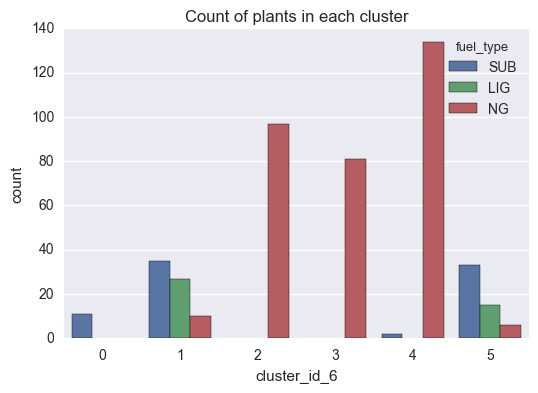

In [96]:
sns.countplot('cluster_id_6', hue='fuel_type', data=fossil_with_ramp)
plt.title('Count of plants in each cluster')

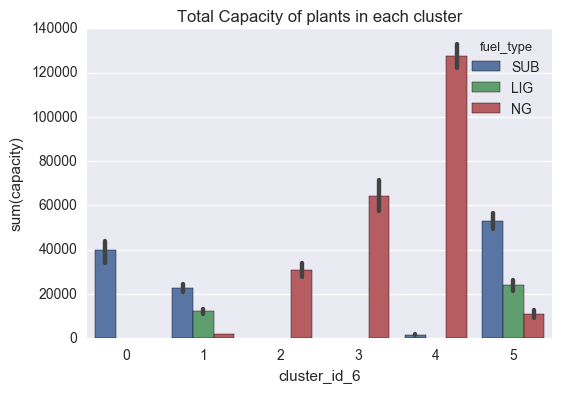

In [97]:
sns.barplot('cluster_id_6', 'capacity', data=fossil_with_ramp, hue='fuel_type',
           estimator=sum)
plt.title('Total Capacity of plants in each cluster')

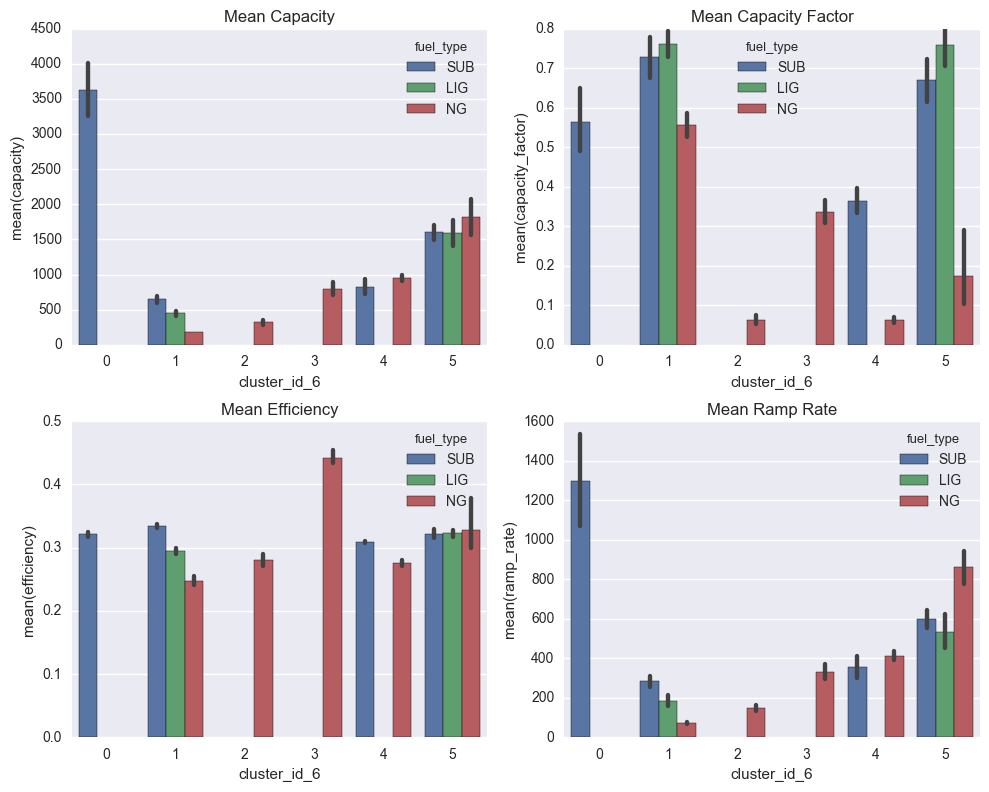

In [94]:
# data = fossil_with_ramp.drop(drop_columns, axis=1)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,8))
sns.barplot('cluster_id_6', 'capacity', data=fossil_with_ramp, hue='fuel_type', ax=ax1)
ax1.set_title('Mean Capacity')
sns.barplot('cluster_id_6', 'capacity_factor', data=fossil_with_ramp, hue='fuel_type', ax=ax2)
ax2.set_title('Mean Capacity Factor')
sns.barplot('cluster_id_6', 'efficiency', data=fossil_with_ramp, hue='fuel_type', ax=ax3)
ax3.set_title('Mean Efficiency')
sns.barplot('cluster_id_6', 'ramp_rate', data=fossil_with_ramp, hue='fuel_type', ax=ax4)
ax4.set_title('Mean Ramp Rate')
# sns.barplot('Climate', 'HDD65', data=house, ax=ax2)

# # Shrink the point sizes (scale), change the estimator from mean to median
# sns.pointplot('Climate', 'HDD65', data=house, scale=0.7, estimator=np.median, ax=ax3)

# # Adjust the bandwidth (smoothing)
# sns.violinplot('Climate', 'HDD65', data=house, ax=ax4, bw=0.4)

plt.tight_layout()